# __Interactional Influence Test: Bayesian Echo Chamber__

In [1]:
import sys, pickle, os
import subprocess, sklearn 
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib
import matplotlib.pyplot as plt 
import networkx as nx
import seaborn
import IPython.display 
from matplotlib.patches import FancyArrowPatch, Circle

%matplotlib inline

## Bayesian Echo Chamber

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

The data has already been convered into XML by the TalkBank team. This is available to download from [GitHub](https://github.com/richardkwo/bayesian-echo-chamber). Once converted we run the Bayesian Echo Chamber to get estimations. Parameters used for this are detailed in the python files

In [2]:
# Load results
output_fname = '06-1195.xml'
result_path = './results/'+output_fname.split('.')[0]+os.path.sep

In [44]:
df_meta_info = pd.read_table(result_path+ 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path+"SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True)
df_influence = pd.read_csv(result_path+ 'SAMPLE-influence.txt',delim_whitespace=True)
df_log_prob.head()

,log.prior,log.likelihood,log.likelihood.test.set
0,-10689.514799,-15263.973692,-2468.135320
1,-10715.006755,-15255.470708,-2465.509423
2,-10729.321577,-15250.020885,-2467.309946
3,-10728.376165,-15249.018291,-2465.027296
4,-10735.431934,-15248.371177,-2461.971037


In [4]:
df_log_prob.shape, df_influence.shape
df_participants = pd.read_csv(result_path+ 'cast.txt',delim_whitespace=True)
df_participants.head()

,agent.num,agent.name
0,1,ROSEN
1,2,SCAL
2,3,SMITH
3,4,SOUT
4,5,BREY


In [9]:
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
person_id

{'ROSEN': 0, 'SCAL': 1, 'SMITH': 2, 'SOUT': 3, 'BREY': 4, 'GINS': 5, 'REHN': 6}

In [11]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = gaussian_kde(data)
    width = np.max(data)-np.min(data)
    xs = np.linspace(np.min(data)-width/5,np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs,density(xs)

## MCMC Trace and Density of log-Likelihoods

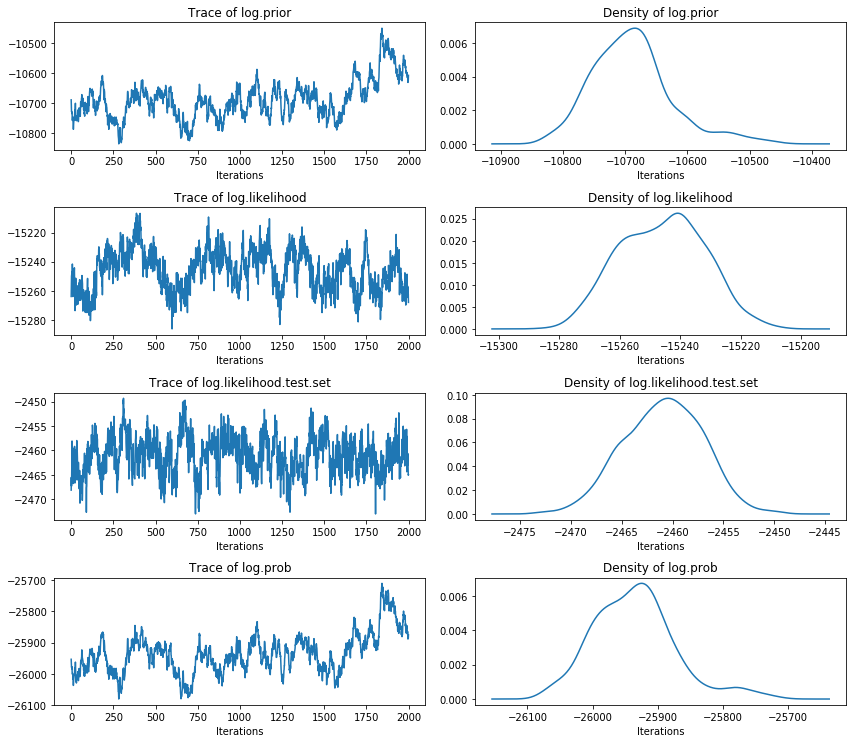

In [47]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])Funding Apps
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()
plt.show()

## Influence Matrix between Participants

In [13]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [14]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [15]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

MEAN of influence matrix (row=from, col=to)


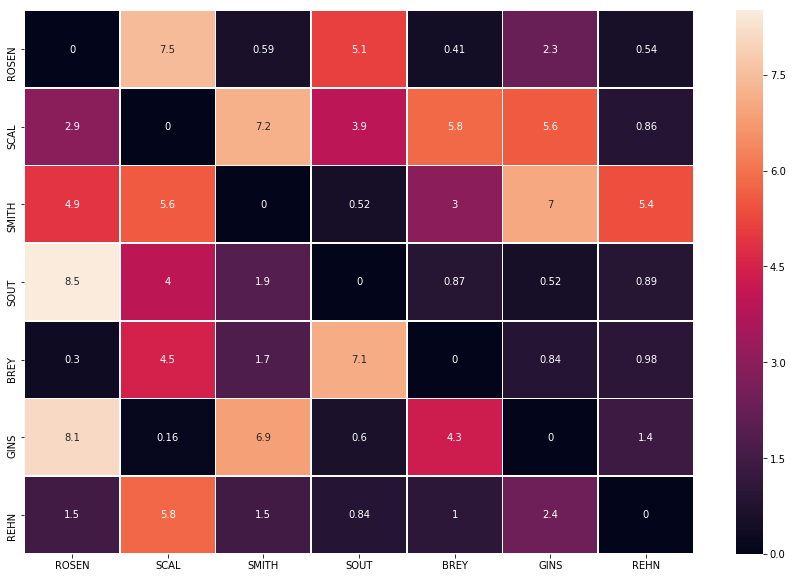

In [30]:
f, ax = plt.subplots(figsize=(15, 10))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax)
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


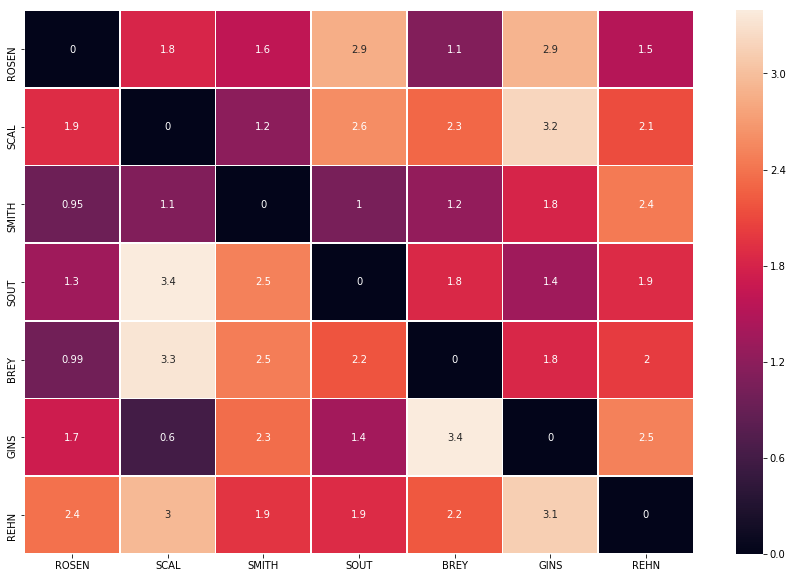

In [31]:
f, ax = plt.subplots(figsize=(15, 10))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax)
print('SD of influence matrix (row=from, col=to)')
plt.show()

## Total Influences Sent/Received

In [19]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

### Total influence

			Total linguistic influence sent/received


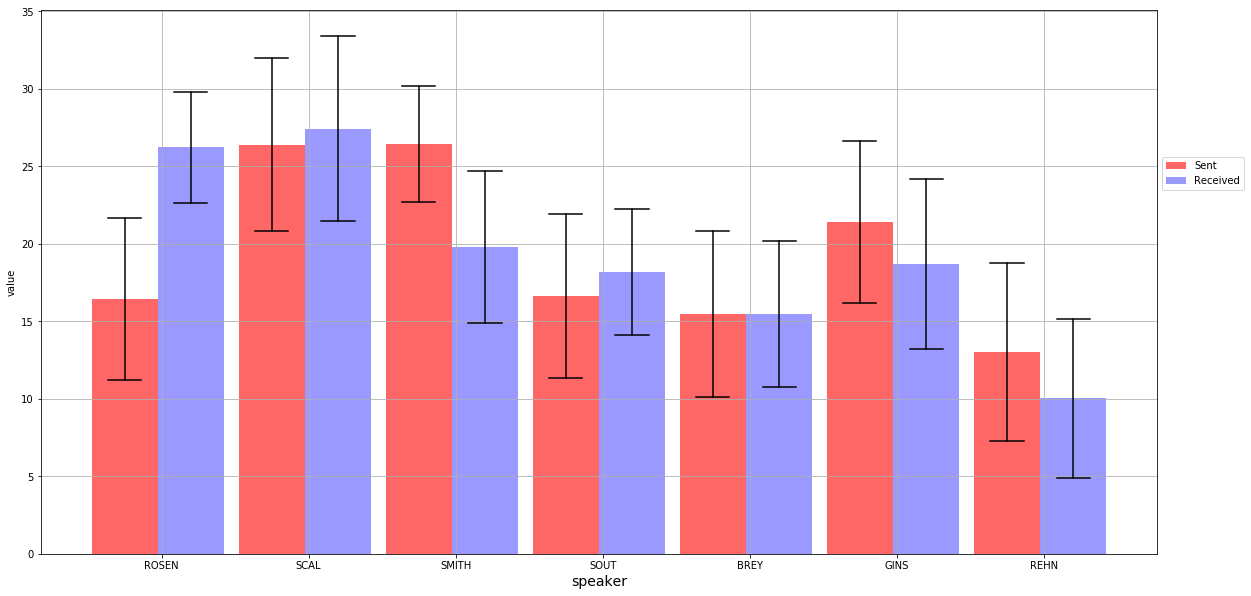

In [27]:
print ("\t\t\tTotal linguistic influence sent/received")
ax.fig = plt.figure(figsize=(20,10))

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

# Visualising Influence Network

In [79]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return G, weights

In [38]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

In [89]:
print(G_mean_network.get_edge_data('ROSEN', 'SOUT'))

{'weight': 5.146301466732337}


In [84]:
print(nx.info(G_mean_network))

Name: 
Type: DiGraph
Number of nodes: 7
Number of edges: 49
Average in degree:   7.0000
Average out degree:   7.0000


In [73]:
dcentralities = nx.degree_centrality(G_mean)
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:7]

[('ROSEN', 2.333333333333333),
 ('SCAL', 2.333333333333333),
 ('SMITH', 2.333333333333333),
 ('SOUT', 2.333333333333333),
 ('BREY', 2.333333333333333),
 ('GINS', 2.333333333333333),
 ('REHN', 2.333333333333333)]

In [74]:
bcentralities = nx.betweenness.betweenness_centrality(G_mean)
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[:7]

[('ROSEN', 0.0),
 ('SCAL', 0.0),
 ('SMITH', 0.0),
 ('SOUT', 0.0),
 ('BREY', 0.0),
 ('GINS', 0.0),
 ('REHN', 0.0)]

In [75]:
ccentralities = nx.closeness_centrality(G_mean)
sorted(ccentralities.items(), key = lambda x: x[1], reverse = True)[:7]

[('ROSEN', 1.0),
 ('SCAL', 1.0),
 ('SMITH', 1.0),
 ('SOUT', 1.0),
 ('BREY', 1.0),
 ('GINS', 1.0),
 ('REHN', 1.0)]

In [91]:
ecentralities = nx.eigenvector_centrality(G_mean_network, weight=True)
sorted(ecentralities.items(), key = lambda x: x[1], reverse = True)[:7]

[('ROSEN', 0.37796447300922725),
 ('SCAL', 0.37796447300922725),
 ('SMITH', 0.37796447300922725),
 ('SOUT', 0.37796447300922725),
 ('BREY', 0.37796447300922725),
 ('GINS', 0.37796447300922725),
 ('REHN', 0.37796447300922725)]

Mean Influence Network


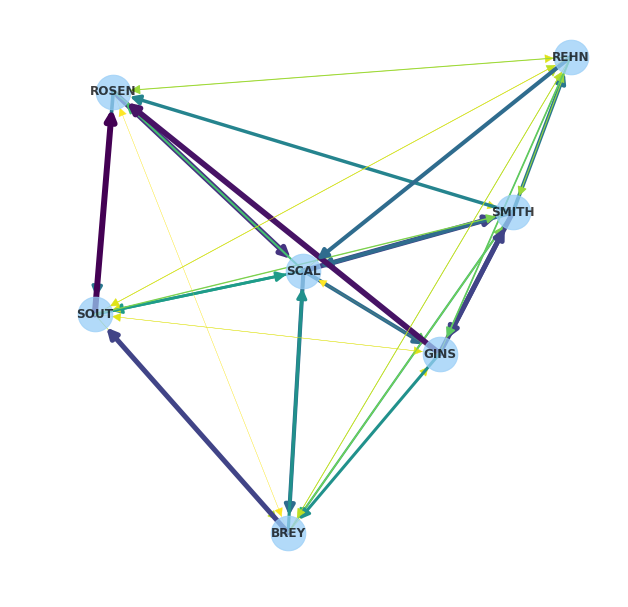

In [80]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


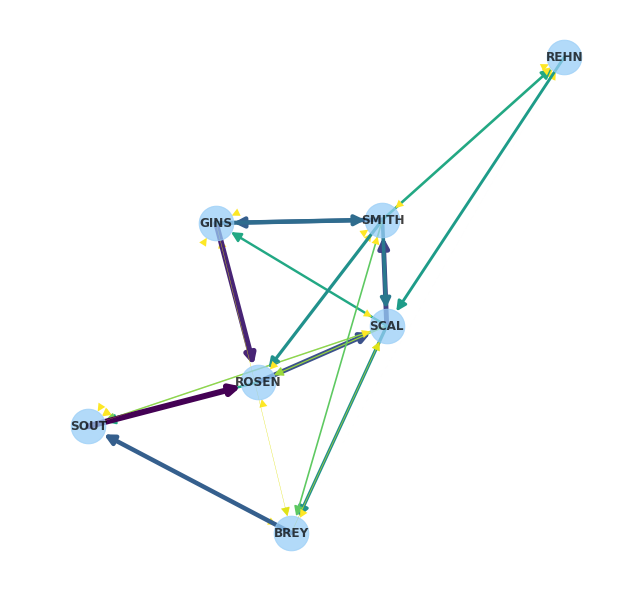

In [40]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


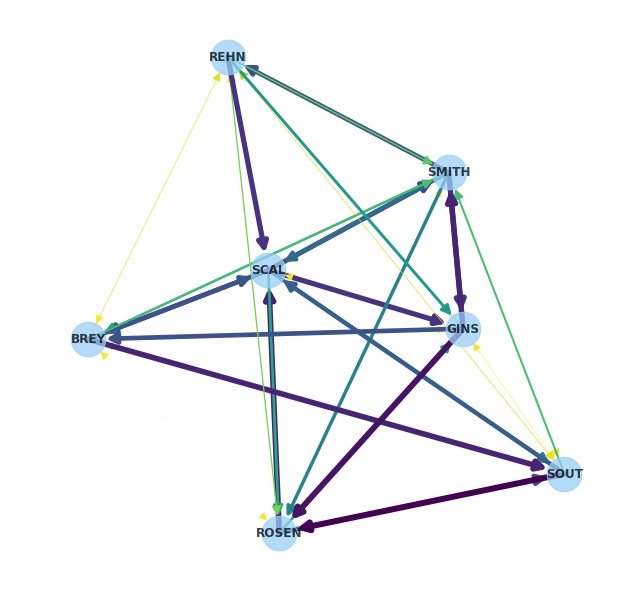

In [41]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')